In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import glob
import os

from math import log

plt.style.use('ggplot') # Make the graphs a bit prettier

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("~/dev/ma/data/results/plm_scaling/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
frames['program_run']['worker_label'] = frames['program_run']['hosts'].map(str) + 'x' + frames['program_run']['workers_per_host'].map(str)

In [15]:
frames['program_run']['graph'].unique()

array(['/home/kit/iti/kp0036/graphs/uk-2002.metis-preprocessed-*.bin',
       '/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_10000000-preprocessed-*.bin',
       '/home/kit/iti/kp0036/graphs/com-friendster-preprocessed-*.bin'], dtype=object)

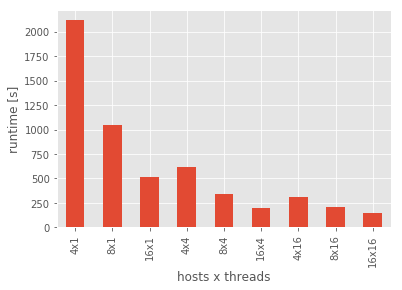

In [7]:
ax = frames['algorithm_run'] \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.node_count == 10000000] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime', legend=False)
    
ax.set_ylabel("runtime [s]")
ax.set_xlabel("hosts x threads")

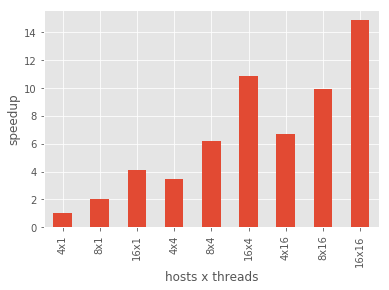

In [8]:
plot_data = frames['algorithm_run'] \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.node_count == 10000000] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

(0.59, 0.605)

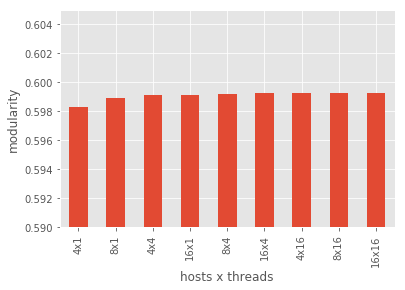

In [13]:
ax = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.node_count == 10000000] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='modularity', legend=False)
    
ax.set_ylabel("modularity")
ax.set_xlabel("hosts x threads")
ax.set_ylim(0.59,0.605)

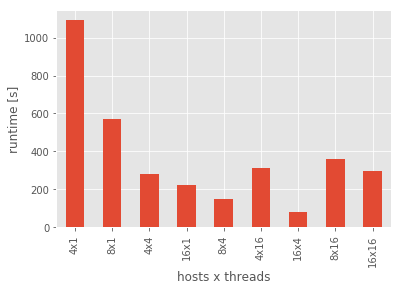

In [16]:
ax = frames['algorithm_run'] \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.graph.str.contains('uk-2002')] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime', legend=False)
    
ax.set_ylabel("runtime [s]")
ax.set_xlabel("hosts x threads")

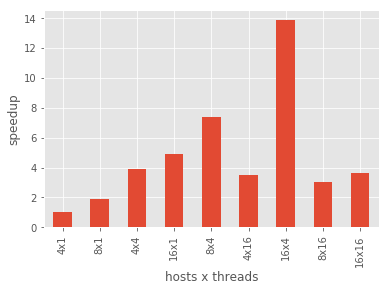

In [17]:
plot_data = frames['algorithm_run'] \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.graph.str.contains('uk-2002')] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

(0.987, 0.992)

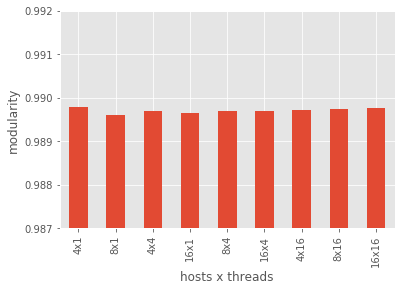

In [20]:
ax = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.graph.str.contains('uk-2002')] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='modularity', legend=False)
    
ax.set_ylabel("modularity")
ax.set_xlabel("hosts x threads")
ax.set_ylim(0.987,0.992)

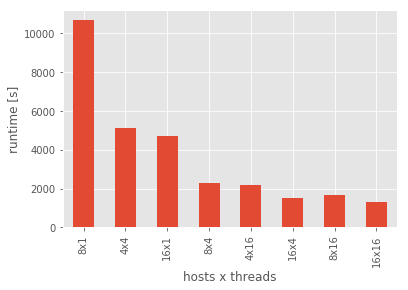

In [21]:
ax = frames['algorithm_run'] \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.graph.str.contains('com-friendster')] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime', legend=False)
    
ax.set_ylabel("runtime [s]")
ax.set_xlabel("hosts x threads")

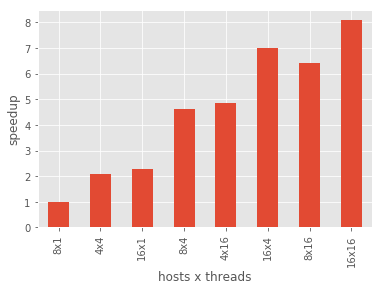

In [22]:
plot_data = frames['algorithm_run'] \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.graph.str.contains('com-friendster')] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

(0.55, 0.62)

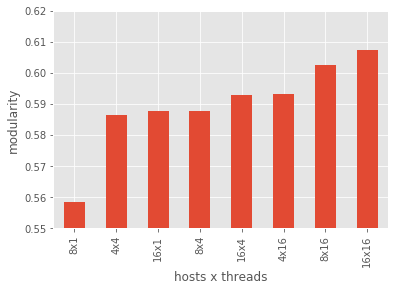

In [25]:
ax = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.graph.str.contains('com-friendster')] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='modularity', legend=False)
    
ax.set_ylabel("modularity")
ax.set_xlabel("hosts x threads")
ax.set_ylim(0.55,0.62)